# reach_analysis_D.ipynb

Parallel version of reach_analysis_C.

Learn to reach, perform radial reaches, and do the analyses that concern the characteristics of the reach.

In [1]:
%cd /home/z/projects/draculab/

/home/z/projects/draculab


In [2]:
from draculab import *
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time
#from tools.visualization import plotter
from multiprocessing import Pool
import copy
import pickle
from enum import Enum

In [3]:
from pathos.multiprocessing import ProcessingPool

In [4]:
%cd ./notebook/spinal/
#%cd /home/z/projects/draculab/notebook/spinal/
from net_builders import *
%cd ../..

/home/z/projects/draculab/notebook/spinal
/home/z/projects/draculab


In [5]:
class sim_config(Enum):
    C_LEARNS = 1
    M_LEARNS = 2
    STATIC_CONN = 3
    C_LEARNS_SYNE = 4
    C_LEARNS_ROT = 5
    
class configurations():
    """ Class that contains the 5 basic config dictionaries. """
    def __init__(self):
        self.config = {
            't_pres_l' : 40., # presentation time for random target reaches
            'n_reaches_l' : 16, # number of targets presented for initial learning
            'rdc_on_M' : False, # whethter to use rate distribution control on M
            'set_C_delay' : False, # whether set C_cid using analytical approach
            'rand_targets' : True, # whether to train using a large number of random targets
            'permute_targets' : True, # whether to permute target order during radial reaches
            'r' : .1, # distance from target to center during radial reaching
            't_pres' : 5., # new presentation time for radial reaching
            'n_trgs' : 8, # number of targets for radial reaching
            'n_rounds' : 6, # number of times the n_trgs targets will be presented
            'par_heter' : 0.01, # heterogeneity of some parameters
            't_smp' : 4., # time to sample M for PD analysis
            'new_noise' : 0, # C unit sigma value during radial reaching.
            'new_gain' : 1. # muscle gain multiplier during radial reaching
        }
        
    def get_config(self, sim_type):
        """ Return the config dictionary for a given simulation type. 
        
            Args:
                sym_type: a sim_config Enum with one of the 5 configuration types.
            Returns:
                dictionary with full configuration for the reach_ana function.
        """
        full_config = self.config.copy()
        full_config['label'] = sim_type.name
        
        if sim_type.value == sim_config.STATIC_CONN.value:
            full_config['rga_on_M'] = False # whether to use rga_21 connections on SPF__M
            full_config['M_noise'] = False # whether M units are noisy (use euler_maru integrator)
            full_config['C_noise'] = False # whether C units are noisy (use euler_maru integrator)
            full_config['M__C_rand_w'] = False # whether to randomly intialize weights for the M__C connections
            full_config['old_M__C'] = False # when using hand-set M__C connections  (e.g. M__C_rand_w=False)
                         # old_M__C=False uses permutted M with no negative connections
            full_config['M__M_conns'] = True
            full_config['rot_SPF'] = False # whether to rotate the SPF output
            full_config['use_syne'] = False # whether to use the version of the network with "synergies"
            full_config['cfg'] = {
                'A__C_lrate': 22.5,
                'A__C_w_max_frac': 0.32,
                'A__C_w_sum': 2.0,
                'A__M_lrate': 26.17,
                'A__M_w_max_frac': .2,
                'A__M_w_sum': 1.,
                'AL_thresh': 1.1,
                'b_e': 1.0,
                'C__C_antag': 1.83,
                'C__C_p_antag': 0.16,
                'C__C_p_syne': 0.18,
                'C__C_syne': 0.5,
                'C_adapt_amp': 0.0,
                'C_cid': 0.15,
                'C_sigma': 0.4,
                'C_slope': 1.7,
                'C_tau': 0.15, #0.07,
                'C_tau_slow': 11.0,
                'CE_thresh': 2.13,
                'CE__CI_w': 0.5,
                'CI__CE_w': -1.8,
                'CI_slope': 3.44,
                'CI_tau': 0.018,
                'CI_thresh': 1.63,
                'g_e_03': 22.37,
                'g_e_factor': 3.0,
                'II_g_03': 7.46,
                'k_pe_e': 20.0,
                'k_se_e': 20.0,
                'M_adapt_amp': 0.,
                'M__AL_lrate': 0.,
                'M__AL_w_sum': 1.5, #2.86,
                'M__C_lrate': 0.,
                'M__C_w_sum': 1.5, # 0.5
                'M__M_w': -1.0,
                'M_cid': 1.1,
                'M_des_out_w_abs_sum': 2.52,
                'M_tau': 0.05,
                'M_slope': 3.35,
                'M_thresh': 0.68,
                'SF_thresh_03': 0.75,
                'SPF__M_lrate': 500.0,
                'SPF__M_w_sum': 3.73,
                'SPF_des_out_w_abs_sum': 2.98,
                'SPF__SPF_w': -1.77,
                'fitness': 0.024913803408415137,
                'n_evals': 2,
                't_pres': 40.,
                'SF_slope': 3.05
            }
        elif sim_type.value == sim_config.C_LEARNS_ROT.value:
            full_config['rga_on_M'] = False
            full_config['M_noise'] = False
            full_config['C_noise'] = True
            full_config['M__C_rand_w'] = True
            full_config['old_M__C'] = None
            full_config['M__M_conns'] = False
            full_config['rot_SPF'] = True
            full_config['use_syne'] = False
            full_config['cfg'] = {            
                'A__C_lrate': 22.5,
                'A__C_w_max_frac': 0.20557888157843945,
                'A__C_w_sum': 2.8826015150173183,
                'A__M_lrate': 26.17,
                'A__M_w_max_frac': 0.6278486120051014,
                'A__M_w_sum': 0.5271106892558473,
                'AL_thresh': 1.1,
                'b_e': 1.0,
                'C__C_antag': 1.83,
                'C__C_p_antag': 0.16,
                'C__C_p_syne': 0.18,
                'C__C_syne': 0.5,
                'C_adapt_amp': 2.395359128247099,
                'C_cid': 0.3154426686326848,
                'C_sigma': 0.7208728717185617,
                'C_slope': 1.4416613712340323,
                'C_tau': 0.11279456275230793,
                'C_tau_slow': 11.0,
                'CE_thresh': 1.674654849384682,
                'CE__CI_w': 0.5,
                'CI__CE_w': -1.8,
                'CI_slope': 3.633907488558342,
                'CI_tau': 0.018,
                'CI_thresh': 1.6994438303143782,
                'g_e_03': 22.37,
                'g_e_factor': 3.0,
                'II_g_03': 7.46,
                'k_pe_e': 20.0,
                'k_se_e': 20.0,
                'M__AL_lrate': 300.0,
                'M__AL_w_sum': 2.86,
                'M__C_lrate': 500.0,
                'M__C_w_sum': 0.5718291038573159,
                'M__M_w': 0.0,
                'M_cid': 0.94,
                'M_des_out_w_abs_sum': 2.52,
                'M_tau': 0.047,
                'M_slope': 1.170768334955256,
                'M_thresh': 1.3788103017685167,
                'M_sigma': 0.45,
                'SF_thresh_03': 0.75,
                'SPF__M_lrate': 0.0,
                'SPF__M_w_sum': 2.7660212695865316,
                'SPF_des_out_w_abs_sum': 3.23,
                'SPF__SPF_w': -1.77,
                'fitness': 0.02425076074862482,
                'n_evals': 1,
                't_pres': 40.0,
                'SF_slope': 3.0,
                'SPF_M_lrate': 500.0 }
        elif sim_type.value == sim_config.C_LEARNS.value:
            full_config['rga_on_M'] = False
            full_config['M_noise'] = False
            full_config['C_noise'] = True
            full_config['M__C_rand_w'] = True
            full_config['old_M__C'] = None
            full_config['M__M_conns'] = True
            full_config['rot_SPF'] = False
            full_config['use_syne'] = False
            full_config['cfg'] = {  
                'A__C_lrate': 22.5,
                'A__C_w_max_frac': 0.18,
                'A__C_w_sum': 1.68,
                'A__M_lrate': 26.17,
                'A__M_w_max_frac': 0.56,
                'A__M_w_sum': 0.85,
                'AL_thresh': 1.1,
                'b_e': 1.0,
                'C__C_antag': 1.83,
                'C__C_p_antag': 0.16,
                'C__C_p_syne': 0.18,
                'C__C_syne': 0.5,
                'C_adapt_amp': 3.1,
                'C_cid': 0.33,
                'C_sigma': 0.63,
                'C_slope': 1.63,
                'C_tau': 0.14,
                'C_tau_slow': 11.0,
                'CE_thresh': 2.,
                'CE__CI_w': 0.5,
                'CI__CE_w': -1.8,
                'CI_slope': 4.,
                'CI_tau': 0.018,
                'CI_thresh': 1.5,
                'g_e_03': 22.37,
                'g_e_factor': 3.0,
                'II_g_03': 7.46,
                'k_pe_e': 20.0,
                'k_se_e': 20.0,
                'M__AL_lrate': 300.0,
                'M__AL_w_sum': 2.86,
                'M__C_lrate': 500.0,
                'M__C_w_sum': 3.29,
                'M__M_w': -0.93,
                'M_cid': 0.94,
                'M_des_out_w_abs_sum': 2.52,
                'M_tau': 0.047,
                'M_slope': 1.46,
                'M_thresh': 1.3,
                'M_sigma': 0.45,
                'SF_thresh_03': 0.75,
                'SPF__M_lrate': 500.,
                'SPF__M_w_sum': 3.24,
                'SPF_des_out_w_abs_sum': 3.23,
                'SPF__SPF_w': -1.77,
                'fitness': 0.02491251754816184,
                'n_evals': 1,
                't_pres': 40.0,
                'SF_slope': 3.,
                'SPF_M_lrate': 500.0 }
        elif sim_type.value == sim_config.C_LEARNS_SYNE.value:
            full_config['rga_on_M'] = False
            full_config['M_noise'] = False
            full_config['C_noise'] = True
            full_config['M__C_rand_w'] = True
            full_config['old_M__C'] = None
            full_config['M__M_conns'] = True
            full_config['rot_SPF'] = False
            full_config['use_syne'] = True
            full_config['cfg'] = {            
                'A__C_lrate': 22.5,
                'A__C_w_max_frac': 0.17785757836500374,
                'A__C_w_sum': 1.5489290867328447,
                'A__M_lrate': 26.17,
                'A__M_w_max_frac': 0.47055115331365194,
                'A__M_w_sum': 0.5269733904869145,
                'AL_thresh': 1.1,
                'b_e': 1.0,
                'C__C_antag': 1.83,
                'C__C_p_antag': 0.16,
                'C__C_p_syne': 0.18,
                'C__C_syne': 0.5,
                'C_adapt_amp': 3.1,
                'C_cid': 0.3605638288606652,
                'C_sigma': 0.6859027781213456,
                'C_slope': 3.3846358891215536,
                'C_tau': 0.17765185440952685,
                'C_tau_slow': 11.0,
                'CE_thresh': 2.313076428241504,
                'CE__CI_w': 0.5,
                'CI__CE_w': -1.8,
                'CI_slope': 2.4584136116648474,
                'CI_tau': 0.018,
                'CI_thresh': 1.7224417122615483,
                'g_e_03': 22.37,
                'g_e_factor': 3.0,
                'II_g_03': 7.46,
                'k_pe_e': 20.0,
                'k_se_e': 20.0,
                'M__AL_lrate': 300.0,
                'M__AL_w_sum': 2.86,
                'M__C_lrate': 500.0,
                'M__C_w_sum': 3.694337688927602,
                'M__M_w': -1.1363982590380328,
                'M_cid': 0.94,
                'M_des_out_w_abs_sum': 2.52,
                'M_tau': 0.047,
                'M_slope': 2.246355953968214,
                'M_thresh': 1.19421607748966,
                'M_sigma': 0.45,
                'SF_thresh_03': 0.75,
                'SPF__M_lrate': 0.0,
                'SPF__M_w_sum': 3.989179382884881,
                'SPF_des_out_w_abs_sum': 3.23,
                'SPF__SPF_w': -1.77,
                'fitness': 0.02223527862809177,
                'n_evals': 1,
                't_pres': 40.0,
                'SF_slope': 3.0,
                'SPF_M_lrate': 500.0 }       
        elif sim_type.value == sim_config.M_LEARNS.value:
            full_config['rga_on_M'] = True
            full_config['M_noise'] = True
            full_config['C_noise'] = False
            full_config['M__C_rand_w'] = False
            full_config['old_M__C'] = False
            full_config['M__M_conns'] = False
            full_config['rot_SPF'] = False
            full_config['use_syne'] = False
            full_config['cfg'] = {
                'A__C_lrate': 22.5,
                'A__C_w_max_frac': 0.32,
                'A__C_w_sum': 2.0,
                'A__M_lrate': 26.17,
                'A__M_w_max_frac': 0.19,
                'A__M_w_sum': 1.14,
                'AL_thresh': 1.10,
                'b_e': 1.0,
                'C__C_antag': 1.83,
                'C__C_p_antag': 0.16,
                'C__C_p_syne': 0.18,
                'C__C_syne': 0.50,
                'C_adapt_amp': 0.0,
                'C_cid': 0.37,
                'C_sigma': 0.63,
                'C_slope': 1.72,
                'C_tau': 0.075,
                'C_tau_slow': 11.0,
                'CE_thresh': 1.93,
                'CE__CI_w': 0.5,
                'CI__CE_w': -1.8,
                'CI_slope': 3.38,
                'CI_tau': 0.018,
                'CI_thresh': 1.41,
                'g_e_03': 22.37,
                'g_e_factor': 3.0,
                'II_g_03': 7.46,
                'k_pe_e': 20.0,
                'k_se_e': 20.0,
                'M__AL_lrate': 0.0,
                'M__AL_w_sum': 2.86,
                'M_adapt_amp': 2.72,
                'M__C_lrate': 0.0,
                'M__C_w_sum': 2.14,
                'M__M_w': -0.74,
                'M_cid': 0.33,
                'M_des_out_w_abs_sum': 2.52,
                'M_tau': 0.05,
                'M_slope': 2.92,
                'M_thresh': 1.96,
                'M_sigma': 0.62,
                'SF_thresh_03': 0.75,
                'SPF__M_lrate': 527.82,
                'SPF__M_w_sum': 2.6,
                'SPF_des_out_w_abs_sum': 3.19,
                'SPF__SPF_w': -1.77,
                'fitness': 0.024181912532623286,
                'n_evals': 2,
                't_pres': 40.0,
                'SF_slope': 3.05
            }
        else:
            raise ValueError('Invalid simulation configuration')
            
        return full_config
        

In [6]:
# Create configurations for the simulations
#np.random.seed(123456) # always the same random values
#np.random.seed() # arbitrary random seed

n_reps_per_dict = 20 # how many times to test each configuration
all_configs = []
config_generator = configurations()

for config in sim_config:
    for _ in range(n_reps_per_dict):
        all_configs.append(config_generator.get_config(config))

In [7]:
config_generator = configurations()
all_configs = [config_generator.get_config(sim_config['STATIC_CONN'])]
all_configs

[{'t_pres_l': 40.0,
  'n_reaches_l': 6,
  'rdc_on_M': False,
  'set_C_delay': False,
  'rand_targets': True,
  'permute_targets': True,
  'r': 0.1,
  't_pres': 5.0,
  'n_trgs': 8,
  'n_rounds': 1,
  'par_heter': 0.01,
  't_smp': 4.0,
  'new_noise': 0,
  'new_gain': 1.0,
  'label': 'STATIC_CONN',
  'rga_on_M': False,
  'M_noise': False,
  'C_noise': False,
  'M__C_rand_w': False,
  'old_M__C': False,
  'M__M_conns': True,
  'rot_SPF': False,
  'use_syne': False,
  'cfg': {'A__C_lrate': 22.5,
   'A__C_w_max_frac': 0.32,
   'A__C_w_sum': 2.0,
   'A__M_lrate': 26.17,
   'A__M_w_max_frac': 0.2,
   'A__M_w_sum': 1.0,
   'AL_thresh': 1.1,
   'b_e': 1.0,
   'C__C_antag': 1.83,
   'C__C_p_antag': 0.16,
   'C__C_p_syne': 0.18,
   'C__C_syne': 0.5,
   'C_adapt_amp': 0.0,
   'C_cid': 0.15,
   'C_sigma': 0.4,
   'C_slope': 1.7,
   'C_tau': 0.15,
   'C_tau_slow': 11.0,
   'CE_thresh': 2.13,
   'CE__CI_w': 0.5,
   'CI__CE_w': -1.8,
   'CI_slope': 3.44,
   'CI_tau': 0.018,
   'CI_thresh': 1.63,
   'g_

In [7]:
def set_new_targets(net,
                    pops_dict,
                    r,
                    t_pres,
                    n_trgs,
                    n_rounds,
                    pds,
                    permute_targets=True):
    """ Set new targets for reaching.
        
        Args:
            net: the draculab network
            pops_dict: dictionary with unit IDs for each population
            r: distance from center to targets
            t_pres: new presentation time
            n_trgs: number of targets
            n_rounds: number of times the n_trgs targets will be presented
            pds : parameter dictionaries used to calculate SP values.
            permute_targets: (boolean) are targets presented permuted?
            
        Returns:
            hand_coords : list with target coordinates (each a numpy 2-array).
            targets : list, only with targets
            center : only the center coordinates
            trg_ids: target used for each presentation
    """
    
    start_t = net.sim_time # starting time for new simulation
    # 8 radial targets in sequence, from 0 to 315 degrees
    r = 0.1 # distance from center to targets
    center = np.array([0.3, 0.3]) # initial hand location
    angs = np.linspace(0., 2.*np.pi, n_trgs+1)[:-1]
    circle = np.array([np.array([np.cos(ang),np.sin(ang)]) for ang in angs])
    targets = center + r*circle # coordinates of the targets

    if permute_targets:
        # version with permuted targets, all are seen every 8 presentations
        trg_ids = np.random.permutation(n_trgs*n_rounds)%n_trgs # target for each presentation
        hand_coords = []
        for idx in trg_ids:
            hand_coords += [center, targets[idx]]
        hand_coords += [center] # to avoid indexes out of bounds
    else:    
        # version with sequential targets
        hand_coords = [center, targets[0],
                       center, targets[1],
                       center, targets[2],
                       center, targets[3],
                       center, targets[4],
                       center, targets[5],
                       center, targets[6],
                       center, targets[7]]
        hand_coords = n_rounds * hand_coords # many repetitions of the same sequence
        hand_coords += [center] # to avoid indexes out of bounds
        trg_ids = np.arange(len(hand_coords))%n_trgs # target for each presentation

    SP = pops_dict['SP']
    A = pops_dict['A']
    P = pops_dict['P']
    #### next is a copy-pasta of the code to set the SP values
    # list with muscle lengths corresponding to the hand coordinates
    m_lengths = []
    for coord in hand_coords:
        m_lengths.append(net.plants[P].coords_to_lengths(coord))
    m_lengths = np.array(m_lengths)
    #(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)
    # We need to translate these lengths to corresponding SF activity levels.
    # For that it is necessary to recreate all their transformations
    # The first transformation is from length to II afferent activity.
    ### OUT OF THE 36 AFFERENT SIGNALS, WE TAKE II ###
    par = net.plants[P].m_params
    # steady state tensions in the static and dynamic bag fibers (no gamma inputs)
    Ts_ss = (par['k_se_s']/(par['k_se_s']+par['k_pe_s'])) * (
             par['k_pe_s']*(m_lengths - par['l0_s']))
    Td_ss = (par['k_se_d']/(par['k_se_d']+par['k_pe_d'])) * (
             par['k_pe_d']*(m_lengths - par['l0_d']))
    # steady state afferent outputs (no gamma inputs)
    #Ia_ss = par['fs']*(Ts_ss/par['k_se_s']) + (1.-par['fs'])*(Td_ss/par['k_se_d'])
    II_ss = par['se_II']*(Ts_ss/par['k_se_s']) + ((1.-par['se_II'])/par['k_pe_s'])*Ts_ss
    #Ia_ss *= par['Ia_gain']
    II_ss *= par['II_gain']
    #Ia_II_ss = np.concatenate((Ia_ss, II_ss), axis=1)
    # Next transformation is through the afferent units
    P__A_ws = np.array(pds['P__A_syn']['init_w'][12:18])
    #Ia_II_avgs = np.mean(Ia_II_ss, axis=0)  # when using hundreds of random targets
    # target averages
    A_thr = np.array([net.units[u].thresh for u in A[12:18]])
    A_II = np.log(1. + np.maximum((II_ss)*P__A_ws - A_thr, 0.))
    #(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)
    # Next is from A to SF
    SF_arg = pds['A__SF_syn']['init_w']*A_II
    SF_params = pds['SF_params']
    SF_out = 1./ (1. + np.exp(-SF_params['slope']*(SF_arg - SF_params['thresh'])))
    SF_params['init_val'] = SF_out # this might cause a smooth start
    # now we set the values in SP
    #m_idxs = np.random.randint(len(hand_coords), size=1000) # index of all targets
    m_idxs = list(range(len(hand_coords)+1)) # reach list targets sequentially
        #m_idxs[0] = 0 # for testing
    A_us = [net.units[u] for u in A]

    def SF_sigmo(idx, arg):
        """ The sigmoidal function for SF unit with index SF[idx]. """
        return 1./ (1. + np.exp(-SF_params['slope'][idx]*(arg - SF_params['thresh'][idx])))

    def cur_target(t):
        """ Returns the index of the target at time t. """
        return m_idxs[int(np.floor((t-start_t)/t_pres))]

    def make_fun(idx):
        """ create a function for the SP unit with index 'idx'. """
        return lambda t: SF_sigmo(idx, 
                            pds['A__SF_syn']['init_w'][idx] * (
                            np.log(1. + max(II_ss[cur_target(t)][idx] * P__A_ws[idx] - 
                            net.units[A[12+idx]].thresh, 0.))))

    for idx, u in enumerate(SP):
        net.units[u].set_function(make_fun(idx))
        
    return hand_coords, targets, center, trg_ids, m_idxs

In [8]:
# Functions to arrange the multiunit data from the various reaches
def get_tensor(series, J, K, T, trg_ids):
    """ Given a simulation time series, arrange it by reach and repetition.
    
        Args:
            series : a time series, spanning simtime2 seconds, in min_delay steps.
            J : number of targets in the simulation.
            K : number of repetitions of each target.
            T : number of time steps that each target is presented.
            
        Returns:
            tensor : a 3-dimensional array. tensor(j,k,t) is the value of the series
                     for target j, on the k-th repetition, at time step t. Time steps
                     begin anew for each reach.
    """
    tensor = np.zeros((J, K, T))
    trg_reps = np.zeros(J, dtype=int) # how many repetitions of each target we have filled

    for reach, trg in enumerate(trg_ids):
        init_tid = (1 + 2 * reach) * T
        final_tid = init_tid + T # t_pres seconds later
        tensor[trg, trg_reps[trg],:] = series[init_tid:final_tid]
        trg_reps[trg] += 1
        
    return tensor

def get_pop_tensor(pop, J, K, T, t_strt, t_pres, trg_ids, data, md):
    """ Returns a tensor with the activities in a population arranged by target and repetition.
    
        Args:
            pop : a list with the IDs of the populations units in the 'data' matrix.
            J : number of targets in the simulation.
            K : number of repetitions of each target.
            T : number of time points to sample per reach (min_delay units)
            t_strt : time after target onset when sample begins (seconds)
            t_pres : time that a full reach lasts (seconds)
            trg_ids : trg_ids[i] is the target at the i-th reach
            data: the simulation data (unit activities)
            md : network time step (e.g. net.min_delay)
        Returns:
            tensor : a 4-dimensional array. tensor(i,j,k,t) is the activity of the i-th
                     unit, when reaching target j, on the k-th repetition, at time step t.
    """
    idx_strt = int(t_strt / md)
    I = len(pop)
    tensor = np.zeros((I,J,K,T), dtype=np.float_)

    trg_reps = np.zeros(J, dtype=int) # how many repetitions of each target we have filled
    pt_per_pres = int(round(t_pres / md))
    
    if T > pt_per_pres:
        raise ValueError('Number of sample points larger than points in a reach')
        
    for reach, trg in enumerate(trg_ids):
        init_tid = (1 + 2 * reach) * pt_per_pres + idx_strt
        final_tid = init_tid + T
        tensor[:, trg, trg_reps[trg],:] = data[pop, init_tid:final_tid]
        trg_reps[trg] += 1
        
    return tensor

In [9]:
# Circular dynamics analyisis in a function
def jpca_ana(pop, t_smp, t_strt, t_pres, J, K, trg_ids, data, md, wid=0.4, normalize=True):
    """ Returns some measures relate to the level of circular dynamics.
    
        Args:
            pop: IDs of the units to be analyzed.
            t_smp: how many seconds will be included per reach.
            t_strt: time after target presentation when sample begins.
            t_pres: duration of a full reach (seconds)
            J: number of targets.
            K: number of presentations per target.
            trg_ids: IDs of the targets presented in radial reaching
            data: the simulation data (unit activites)
            md : network time step (e.g. net.min_delay)
            wid: width of window around pi/2 where angles are "orthogonal".
            normalize: if True, the population responses are normalized.
        Returns:
            A dictionary with the following entries:
            'var_per':array with variance percentages for the 3 jPCA planes.
            'orth_fr': fraction of "orthogonal" angles between X, Xp
            'R2_uncons': coefficent of determination for unconstrained model
            'R2_skew:: Coef. of Det. for skew-symmetric model.
            't_smp': the t_smp argument.
            't_strt': the t_strt argument.
    """
    idx_strt = int(t_strt / md)
    I = len(pop)
    T = int(t_smp / md) # number of time points
    m_tensor = get_pop_tensor(pop, J, K, T, t_strt, t_pres, trg_ids, data, md)
    
    # Normalize responses in m_tensor
    if normalize:
        for i in range(I):
            for j in range(J):
                for k in range(K):
                    norm = np.linalg.norm(m_tensor[i,j,k,:])
                    m_tensor[i,j,k,:] = m_tensor[i,j,k,:] / norm
                
    # Now we average across repetitions for the same target
    p_tensor = m_tensor.sum(axis=2) / K

    # We obtain the across-condition average
    a_tensor = p_tensor.sum(axis=1) / J

    # Obtained a normalized average trace per condition
    c_tensor = np.zeros_like(p_tensor)
    for trg in range(J):
        c_tensor[:, trg, :] = p_tensor[:, trg, :] - a_tensor
    X = np.zeros((J*T,I))
    for j in range(J):
        X[j*T:(j+1)*T, :] = c_tensor[:,j,:].transpose()
    # create the block-matrix version of X
    Xtilde = sp.linalg.block_diag(*([X]*I))
    # Create the H matrix
    n = X.shape[1]
    ct = X.shape[0]
    L = np.zeros((n,n), dtype=int)
    c = 0
    for row in range(n):
        for col in range(row+1, n):
            L[row, col] = c
            L[col, row] = c
            c += 1
    H = np.zeros((n*n, int(0.5*n*(n-1))))
    for col in range(n):
        for row in range(n):
            if col > row:
                H[n*col+row, L[col,row]] = 1.
            elif row > col:
                H[n*col+row, L[col,row]] = -1.
    # Approximate the derivatives of X
    Xp = np.zeros_like(X)
    Xp[1:,:] = (X[1:,:] - X[:-1,:]) / md
    xp = Xp.flatten('F')
    kstar = np.matmul(np.linalg.pinv(np.matmul(Xtilde, H)), xp)
    # reconstruct the matrix that generated the data
    Mstar = np.matmul(H, kstar).reshape(n,n)
    # Next,extract the eigenvalues of M.
    eig_vals, eig_vecs = np.linalg.eig(Mstar)
    eig_vals_norms = np.sqrt((eig_vals * eig_vals.conj()).real)
    ev_sum = eig_vals_norms.sum()/2.1
    var_percentages = eig_vals_norms[np.array([0,2,4])] / ev_sum
    
    # 1) average angle between X and Xp
    X_norms = np.linalg.norm(X, axis=1)
    Xp_norms = np.linalg.norm(Xp, axis=1)
    X_cos = (X * Xp).sum(axis=1) / (X_norms * Xp_norms + 1e-10)
    X_angs = np.arccos(X_cos)

    orth_fr = ((X_angs < np.pi/2+wid) & (X_angs > np.pi/2-wid)).sum() / len(X_angs)

    # 2) Coefficients of determination
    # 2.1) Obtain unconstrained M matrix
    M_uncons = np.matmul(np.linalg.pinv(X), Xp)
    # 2.2) Reconstruct Xp with M_uncons
    Xp_uncons = np.matmul(X, M_uncons)
    # 2.3) Reconstruct Xp with Mstar
    Xp_skew = np.matmul(X, Mstar)
    # 2.4) Calculate residual sums of squares
    SSres_uncons = ((Xp - Xp_uncons) * (Xp - Xp_uncons)).sum()
    SSres_skew = ((Xp - Xp_skew) * (Xp - Xp_skew)).sum()
    # 2.5) Calculate the total sum of squares
    SStot = ((Xp-Xp.mean())*(Xp-Xp.mean())).sum()
    # 2.6) Calculate coefficients of determination
    R2_uncons = 1. - (SSres_uncons / SStot)
    R2_skew = 1. - (SSres_skew / SStot)
    
    return {'var_per': var_percentages,
            'orth_fr': orth_fr,
            'R2_uncons': R2_uncons,
            'R2_skew': R2_skew,
            't_smp': t_smp,
            't_strt': t_strt}

In [10]:
def ang_diff(a1, a2):
    """ Difference between two angles in the range [-pi, pi]. """
    big_a = max(a1,a2)
    lil_a = min(a1,a2)
    if lil_a < 0 and big_a > 0:
        diff = min(np.pi-big_a - lil_a, big_a-lil_a)
    else:
        diff = big_a - lil_a
    return diff

In [11]:
def reach_ana(arg_dict):
    """ Given a parameter configuration, analyze the reaching it produces.
        
        A fresh random seed is produced each time this function is invoked.
        
        Args:
        arg_dict: a dictionary with these entries.-
            cfg: parameter dictionary
            t_pres_l: presentation time for random target reaches
            n_reaches_l: number of targets presented for initial learning
            rdc_on_M: whethter to use rate distribution control on M
            set_C_delay: whether set C_cid using analytical approach
            rand_targets: whether to train using a large number of random targets
            permute_targets: whether to permut target order during radial reaches
            r: distance of radial targets from center.
            t_pres: target presentation time during radial reaching.
            n_trgs: number of targets for radial reaching
            n_rounds: number of times to present each radial target
            par_heter: level of parameter heterogeneity
            rga_on_M: whether to use rga_21 connections on SPF->M
            M_noise: whether M units are noisy (use euler_maru integrator)
            C_noise: whether C units are noisy (use euler_maru integrator)
            M__C_rand_w: whether to randomly intialize weights for the M__C connections
            old_M__C: when using hand-set M__C connections  (e.g. M__C_rand_w=False),
                      old_M__C=False uses permutted M with no negative connections
            M__M_conns: whether to create internal connections in M
            rot_SPF: whether to rotate the SPF output
            use_syne: whether to use the version of the network with "synergies"
            t_smp: time to sample M for preferred directions (seconds)
            new_noise: C(M) sigma value during radial reaching. M if rga_on_M
            new_gain: muscle gain multiplier during radial reaching.
            
        Returns:
        A dictionary with these entries:
        error_l: mean distance to target during the learning phase.
        error_l_4: mean distance to target in the last 4 learning reaches.
        first_reach: first learning reach with average distance < 10 cm.
        error_r: mean distance to target during radial reaches.
        cs_of_d: Coeffs. of determination for M direction tuning.
        R_pred: Coeff. of determination for predicted angle (weighted)
        n_tuned: Number of M units with significant direction tuning.
        pred_frac: Fraction of reaches predicted with M preferred directions.
        bimodal: whether the big PD vectors have a bimodal distribution (Boolean)
        sc_dom_ang_deg: angle of dominant axis for PD distribution in degrees
        max_var_per: maximum variance percentage in first jPCA plane
        max_orth_fr: maximum fraction of orthogonal angles between X and Xp
        max_vp_of: maximum of the product of max_var_per*max_orth_fr
        var_per: variance % in 1st jPCA plane, t_smp=.5, t_strt=0.2, normalize=False
    """
    np.random.seed() # arbitrary random seed
    
    cfg = arg_dict['cfg']
    t_pres_l = arg_dict['t_pres_l']
    rdc_on_M = arg_dict['rdc_on_M']
    n_reaches_l=arg_dict['n_reaches_l']
    set_C_delay=arg_dict['set_C_delay']
    rand_targets=arg_dict['rand_targets']
    permute_targets=arg_dict['permute_targets']
    r=arg_dict['r']
    t_pres = arg_dict['t_pres']
    n_trgs = arg_dict['n_trgs']
    n_rounds=arg_dict['n_rounds']
    par_heter = arg_dict['par_heter']
    rga_on_M = arg_dict['rga_on_M']
    M_noise = arg_dict['M_noise']
    C_noise = arg_dict['C_noise']
    M__C_rand_w = arg_dict['M__C_rand_w']
    old_M__C = arg_dict['old_M__C']
    M__M_conns = arg_dict['M__M_conns']
    t_smp = arg_dict['t_smp']
    rot_SPF = arg_dict['rot_SPF']
    use_syne=arg_dict['use_syne']
    new_noise = arg_dict['new_noise']
    new_gain = arg_dict['new_gain']
    #arg_dict['track_weights'] = False
    #arg_dict['track_ips'] = False
    
    if n_reaches_l < 4:
        import warnings
        warnings.warn('Insufficient number of learning reaches')

    if not use_syne:
        #net, pops_dict, hand_coords, m_idxs, pds = net_from_cfg(**arg_dict)
        net, pops_dict, hand_coords, m_idxs, pds = net_from_cfg(cfg,
                                                       t_pres = t_pres_l,
                                                       par_heter = par_heter,
                                                       set_C_delay = set_C_delay,
                                                       rand_targets = rand_targets,
                                                       track_weights = False,
                                                       track_ips = False,
                                                       C_noise = C_noise,
                                                       M__C_rand_w = M__C_rand_w,
                                                       M_noise = M_noise,
                                                       rga_on_M = rga_on_M,
                                                       rdc_on_M = rdc_on_M,
                                                       rot_SPF = rot_SPF,
                                                       M__M_conns = M__M_conns,
                                                       old_M__C = old_M__C)
    else:
        #net, pops_dict, hand_coords, m_idxs, pds = syne_net(**arg_dict)
        net, pops_dict, hand_coords, m_idxs, pds = syne_net(cfg,
                                                        t_pres = t_pres_l,
                                                        par_heter = par_heter,
                                                        set_C_delay = set_C_delay,
                                                        rand_targets = rand_targets,
                                                        track_weights = False,
                                                        track_ips = False,
                                                        C_noise = C_noise,
                                                        M__C_rand_w = M__C_rand_w,
                                                        M_noise = M_noise,
                                                        rga_on_M = rga_on_M,
                                                        rdc_on_M = rdc_on_M,
                                                        rot_SPF = rot_SPF,
                                                        M__M_conns = M__M_conns,
                                                        old_M__C = old_M__C)

    M = pops_dict['M']
    P = pops_dict['P']
    SPF = pops_dict['SPF']
    if use_syne:
        SYNE = pops_dict['SYNE']
        SYNI = pops_dict['SYNI']
    else:
        CE = pops_dict['CE']
        CI = pops_dict['CI']
    
    # parameter dictionaries used to change targets
    P__A_syn = pds['P__A_syn']
    P__A_ws = np.array(P__A_syn['init_w'][12:18])
    A__SF_syn = pds['A__SF_syn']
    SF_params = pds['SF_params']
    
    # Run simulation for initial learning
    sim_time_l = t_pres_l * n_reaches_l
    times_l, data_l, plant_data_l  = net.flat_run(sim_time_l)
    data_l = np.array(data_l)
    
    # obtain error for initial learning
    plant = net.plants[P]
    q1 = plant_data_l[P][:,0]
    q2 = plant_data_l[P][:,2]
    q12 = q1+q2
    c_elbow = np.array((plant.l_arm*np.cos(q1), plant.l_arm*np.sin(q1)))
    c_hand = np.array((c_elbow[0] + plant.l_farm*np.cos(q12),
                       c_elbow[1] + plant.l_farm*np.sin(q12))).transpose()
    coord_idxs = np.floor(times_l/t_pres_l).astype(int)  # before resetting the targets
    # desired coordinates at each moment in time:
    des_coords = np.array(hand_coords)[m_idxs[coord_idxs],:] 
    hand_error = np.linalg.norm(c_hand-des_coords, axis=1)
    error_l = hand_error.mean() # error over the whole learning period
    # obtaining error in the last 4 reaches
    bins_per_reach = int(np.round(t_pres_l / net.min_delay))
    back_idx = len(times_l) - 4*bins_per_reach
    error_l_4 = hand_error[back_idx:].mean()
    # obtaining first reach with mean error smaller than 10 cm
    first_reach = None
    rch_t_strt = 0 # index in times_l where the reach starts in the loop below
    for reach in range(n_reaches_l):
        rch_error = hand_error[rch_t_strt:rch_t_strt+bins_per_reach].mean()
        rch_t_strt += bins_per_reach
        if rch_error < 0.1:
            first_reach = reach+1
            break

    # Set targets for radial reaching
    start_t = net.sim_time # starting time for new simulation
    hand_coords, targets, center, trg_ids, m_idxs = set_new_targets(
        net, pops_dict, r, t_pres, n_trgs, n_rounds, pds)
    # adjust noise from C/SYNE units
    if use_syne:
        for u in [net.units[c] for c in SYNE+SYNI]:
            u.sigma = new_noise
    else:
        for u in [net.units[c] for c in CE+CI]:
            u.sigma = new_noise
    if rga_on_M:
        for u in [net.units[m] for m in M]:
            u.sigma = new_noise
    # adjust the muscle gains
    for idx in range(6):
        net.plants[0].inp_syns[idx][0].w = new_gain
        
    # Run simulation for radial reaches
    sim_time2 = 2. * t_pres * n_trgs * n_rounds
    times, data, plant_data  = net.flat_run(sim_time2)
    data = np.array(data)
    
    # Obtain error for radial reaches
    q1 = plant_data[P][:,0]
    q2 = plant_data[P][:,2]
    q12 = q1+q2
    c_elbow = np.array((plant.l_arm*np.cos(q1), plant.l_arm*np.sin(q1)))
    c_hand = np.array((c_elbow[0] + plant.l_farm*np.cos(q12),
                       c_elbow[1] + plant.l_farm*np.sin(q12))).transpose()
    coord_idxs = np.floor((times-start_t)/t_pres).astype(int) # after resetting the targets
    des_coords = np.array([hand_coords[idx] for idx in [m_idxs[cid] for cid in coord_idxs]])
    hand_error = np.linalg.norm(c_hand-des_coords, axis=1)
    error_r = np.mean(hand_error)
    
    # Obtaining the prefered directions for the units in M
    
    # Find the mean rate for each target
    I = 12 # number of units to consider in M
    J = n_trgs # number of targets in radial reaching
    K = n_rounds # number of times each target is presented
    T = int(t_smp / net.min_delay) # number of time points
    t_st_pd = 0.0 # time to start sampling for PD analysis
    md = net.min_delay
    m_tensor = get_pop_tensor(M[:I], J, K, T, t_st_pd, t_pres, trg_ids, data, md)
    # m_tensor[i,j,k,t] is the activity of the i-th M 
    # unit for target j, on the k-th repetition, at time point t.
    # Now we average across repetitions for the same target
    m_tensor_trg_avg = m_tensor.sum(axis=2) / K
    # m_tensor_trg_avg[i,j,t]: average activity of i-th M unit when
    # reaching for target j, at time point t
    m_avg_rates = np.zeros((I,J)) # average rate at each unit for each target
    for trg in range(J):
        m_avg_rates[:, trg] = np.mean(m_tensor_trg_avg[:, trg, :], axis=1)
    m_means = np.mean(m_avg_rates, axis=1) # mean rate for each unit

    # Obtaining preferred directions by fitting the rates using a plane, and using
    # the angle of the projection of this plane's normal vector onto the XY plane
    # The coefficients of the normal vector can be calculated using the least-squares
    # method, which leads to a 3x3 linear system that is readily reduced to a 2x2 system.
    trgs = targets - center # targets centered at the origin
    xs = trgs[:,0]
    ys = trgs[:,1]
    cxs = xs - np.mean(xs) # "centered" x coordinates
    cys = ys - np.mean(ys) # "centered" Y coordinates

    X11 = (xs * cxs).sum()
    X12 = (xs * cys).sum()
    X21 = (ys * cxs).sum()
    X22 = (ys * cys).sum()

    Amat = np.array([[X11, X12], [X21, X22]])
    detA = np.linalg.det(Amat) # determinant of Amat
    if detA == 0.:
        raise ValueError('Indeterminate system found!')
    invA = np.linalg.inv(Amat)

    prf_angs = np.zeros(len(M)) # preferred angles, in radians
    normal_vecs = [] # list with the vectors normal to the plane fitting the rates

    cs_of_d = np.zeros(I)
    for uid in range(I):
        r1 = (xs * (m_avg_rates[uid, :] - m_means[uid])).sum()
        r2 = (ys * (m_avg_rates[uid, :] - m_means[uid])).sum()
        n = np.matmul(invA, np.array([r1,r2]))
        # boils down to
        #n = [a,b] where b = r2/X22, a = r1/X11
        #normal_vecs.append(n / np.linalg.norm(n)) # appending normalized vector
        normal_vecs.append(n)
        prf_angs[uid] = np.arctan2(n[1], n[0]) # preferred angle
        c = np.mean(m_avg_rates[uid,:] - n[0]*xs - n[1]*ys)
        # obtaining residuals, coefficient of determination, R^2
        residuals = m_avg_rates[uid,:] - n[0]*xs - n[1]*ys - c
        devs = m_avg_rates[uid,:] - m_means[uid]
        SSr = (residuals * residuals).sum()
        SSt = (devs * devs).sum()
        R = 1. - (SSr/SSt)
        cs_of_d[uid] = R

    normal_vecs = np.array(normal_vecs)

    # Get the lengths of the preferred direction vectors
    pd_norms = np.linalg.norm(normal_vecs, axis=1)
    
    # Coefficient of determination for predicted PDs
    # len_diffs[i,j] is the required length of contraction for muscle i, target j, divided by the length in the rest position
    # This is obtained in 'v3_cordC'
    len_diffs = np.array( [[0.        , 0.        , 0.00512814, 0.02957183, 0.03340439, 0.01043197, 0.        , 0.        ],
                           [0.02868621, 0.13750184, 0.16861731, 0.12856412, 0.02810964, 0.        , 0.        , 0.        ],
                           [0.        , 0.        , 0.        , 0.        , 0.        , 0.10604558, 0.16349133, 0.10088526],
                           [0.0308563 , 0.01576455, 0.        , 0.        , 0.        , 0.        , 0.01655006, 0.03257554],
                           [0.        , 0.        , 0.        , 0.        , 0.09134384, 0.13319637, 0.09134384, 0.        ],
                           [0.11777032, 0.16048272, 0.11777032, 0.0165468 , 0.        , 0.        , 0.        , 0.0165468 ]])

    ldiff_vecs = np.zeros((6,2))
    ldiff_angs = np.zeros(6)
    angs = np.linspace(0., 2.*np.pi, J+1)[:-1]
    for idx, lds in enumerate(len_diffs):
        ldiff_vecs[idx,0] = (lds*np.cos(angs)).sum()
        ldiff_vecs[idx,1] = (lds*np.sin(angs)).sum()
        ldiff_angs[idx] = np.arctan2(ldiff_vecs[idx,1], ldiff_vecs[idx,0])
        
    # obtain the connection matrix
    # SPF__M_ws[i,j]: weight from j-th SPF unit to i-th M unit
    SPF__M_ws = np.zeros((len(M), len(SPF)))
    if rot_SPF:
        for m_idx, m in enumerate(M):
            w_list = [syn.w for syn in net.syns[m] if syn.preID in SPF]
            SPF__M_ws[m_idx, :] = w_list
    else:
        SPF__M_ws = np.eye(12)
    # Obtain predicted PD vectors
    pred_pds = np.zeros((12,2)) # predicted PD vectors for the 12 M units
    for m_idx, m_ws in enumerate(SPF__M_ws):
        for idx, vec in enumerate(ldiff_vecs):
            pred_pds[m_idx,:] += (m_ws[idx]-m_ws[idx+6]) * vec
    # angle and norm of the PD vectors
    pred_angs = np.zeros(12)
    pred_norms = np.zeros(12)
    for idx, pd in enumerate(pred_pds):
        pred_angs[idx] = np.arctan2(pd[1], pd[0])
        pred_norms[idx] = np.linalg.norm(pd)
    # Coefficients of determination for the predicted angles ("weighted" version)
    pred_residuals2 = np.array([ang_diff(a1,a2) for a1,a2 in zip(pred_angs, prf_angs)])
    pred_residuals2 = pred_residuals2 * pd_norms
    ang_devs2 = np.array([ang_diff(a1, np.mean(prf_angs)) for a1 in prf_angs])
    ang_devs2 = ang_devs2 * pd_norms
    SSr2 = (pred_residuals2 * pred_residuals2).sum()
    SSt2 = (ang_devs2 * ang_devs2).sum()
    R_pred = 1. - (SSr2/SSt2)
    
    # Assess if significantly tuned to direction
    N_shuffles = 10000 # number of target permutations to produce
    sh_pd_norms = np.zeros((I, N_shuffles)) # magnitude of PD vector for each cell, all shuffles
    #m_rates_tensor = np.mean(m_tensor, axis=3)
    # m_rates_tensor[i,j,k]: mean firing rate for cell i on k-th presentation of target j
    for n_idx in range(N_shuffles):
        sh_trg_ids = np.random.permutation(trg_ids)
        sh_m_tensor = get_pop_tensor(M[:I], J, K, 
                                     T, t_st_pd, t_pres, sh_trg_ids, data, md)
        sh_m_tensor_trg_avg = sh_m_tensor.sum(axis=2) / K
        sh_m_avg_rates = np.zeros((I,J)) # average rate at each unit for each target
        for trg in range(J):
            sh_m_avg_rates[:, trg] = np.mean(sh_m_tensor_trg_avg[:, trg, :], axis=1)
        sh_m_means = np.mean(sh_m_avg_rates, axis=1) # mean rate for each unit
        sh_normal_vecs = np.zeros((I,2))
        for uid in range(I):
            r1 = (xs * (sh_m_avg_rates[uid, :] - sh_m_means[uid])).sum()
            r2 = (ys * (sh_m_avg_rates[uid, :] - sh_m_means[uid])).sum()
            n = np.matmul(invA, np.array([r1,r2]))
            sh_normal_vecs[uid,:] = n
        sh_pd_norms[:, n_idx] = np.linalg.norm(sh_normal_vecs, axis=1)

    # Now, for each unit, find vlue of sh_pd_norms that is larger than 99%
    sig_threshs = np.percentile(sh_pd_norms, 99.9, axis=1)

    # For each unit, check if it is significantly tuned
    tuned = pd_norms >= sig_threshs
    n_tuned = tuned.sum()
    
    # Decode which target was reached based on the  M firing rate
    # We get the sum of prefered directions, each modulated by the
    # average firing rate. The desired target will be the one closest to
    # the decoded direction.
    # We can do this for all individual reaches

    normal_normal_vecs = [vec / np.linalg.norm(vec) for vec in normal_vecs]
    pred_dirs = np.empty((J,K), dtype=np.int_)
    #pred_dirs(j,k): predicted direction on reach j, repetition k
    for target in range(J):
        for reach in range(K):
            # we obtain the average firing rate for all cells at that reach
            m_reach_avg = np.mean(m_tensor[:, target, reach, :], axis=1).reshape(12,1)
            pd = (m_reach_avg * normal_normal_vecs).sum(axis=0).reshape(2,1) # predicted direction
            # We select the target with the largest inner product with pd
            # trgs (obtained before) has the targets centered at the origin
            dot_prods = np.matmul(trgs, pd)
            pred_dir = np.argmax(dot_prods)
            pred_dirs[target, reach] = pred_dir
    
    pdrows, pdcols = pred_dirs.shape
    pred_frac = (np.tile(np.arange(pdrows).reshape(pdrows,1), pdcols) == 
                 pred_dirs).sum() / pred_dirs.size  
    
    # Obtain angle of dominant axis
    mod_prf_angs = [ang if ang > 0. else ang+np.pi for ang in prf_angs]
    sc_dom_ang = np.arctan2((np.sin(mod_prf_angs)*pd_norms).sum(), (np.cos(mod_prf_angs)*pd_norms).sum())
    sc_dom_ang_deg = sc_dom_ang * 180. / np.pi
    
    # Obtaining bimodal Rayleigh r statistics, big norms
    # These are twice the value of those in Lillicrap and Scott 2013
    big_norms_idx = np.arange(len(pd_norms))[pd_norms > np.mean(pd_norms)]
    sig_prf_angs = prf_angs[big_norms_idx]
    r_bimod = 2. * ((np.sin(2.*sig_prf_angs).sum())**2 + 
                    (np.cos(2.*sig_prf_angs).sum())**2) / sig_prf_angs.size
    # Significance threshold
    a = .99
    x_c = np.sqrt(-2.*np.log(1 - a))
    bimodal = r_bimod > x_c
    
    one_jpca = jpca_ana(M[:I], 0.5, 0.2, t_pres, J, K, trg_ids, data, md, normalize=False)
    var_per = max(one_jpca['var_per'])
    
    results = {
            'error_l': error_l,
            'error_l_4': error_l_4,
            'first_reach': first_reach,
            'error_r': error_r, 
            'cs_of_d': cs_of_d,
            'R_pred': R_pred,
            'n_tuned': n_tuned,
            'pred_frac': pred_frac,
            'bimodal': bimodal,
            'sc_dom_ang_deg': sc_dom_ang_deg,
            #'max_var_per':max_var_per,
            #'max_orth_fr':max_orth_fr,
            #'max_vp_of':max_vp_of,
            'var_per': var_per,
            'times_l': times_l, 
            'data_l': data_l, 
            'plant_data_l': plant_data_l,
            'M': M,
            'SPF': SPF,
            'CE': CE,
            'CI': CI,
            'A': pops_dict['A'],
            'SF': pops_dict['SF'],
            'SP': pops_dict['SP'],
            'P': P,
            'net': net}
    
    #print("Run of reach_ana finished, new_gain=%f, new_noise=%f, r=%f"%(new_gain, new_noise,r))
    print('.', end='')
    
    return results

In [13]:
# Single-threaded run
all_results = list(map(reach_ana, all_configs))

/home/z/projects/draculab/requirements/requirements.py:1456: UserWarning: setting the 0 value for the acc_slow reset port
  warn('setting the 0 value for the acc_slow reset port')


.

In [14]:
all_results

[{'error_l': 0.04528276500409599,
  'error_l_4': 0.04898165808007266,
  'first_reach': 1,
  'error_r': 0.051756065351525424,
  'cs_of_d': array([0.66517716, 0.9823009 , 0.98036107, 0.27961599, 0.91943053,
         0.97631918, 0.78391073, 0.98422186, 0.9781919 , 0.34148302,
         0.881132  , 0.96389228]),
  'R_pred': 0.9512548399968955,
  'n_tuned': 4,
  'pred_frac': 0.25,
  'bimodal': True,
  'sc_dom_ang_deg': 59.13731732939644,
  'var_per': 0.415011593150698,
  'times_l': array([0.00000e+00, 5.00000e-03, 1.00000e-02, ..., 2.39985e+02,
         2.39990e+02, 2.39995e+02]),
  'data_l': array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          1.07451435e+00, 1.06904610e+00, 1.06176414e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          1.22309820e+00, 1.22468786e+00, 1.22646095e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          2.02524054e-07, 1.28704396e-07, 7.21135763e-08],
         ...,
         [3.00572785e-01, 4.

In [19]:
times_l = all_results[0]['times_l']
data_l = all_results[0]['data_l']
plant_data_l = all_results[0]['plant_data_l']
M = all_results[0]['M']
SPF = all_results[0]['SPF']
CE = all_results[0]['CE']
CI = all_results[0]['CI']
SF = all_results[0]['SF']
SP = all_results[0]['SP']
P = all_results[0]['P']
A = all_results[0]['A']
n_reaches_l = all_configs[0]['n_reaches_l']
t_pres_l = all_configs[0]['t_pres_l']
use_syne = all_configs[0]['use_syne']
net = all_results[0]['net']

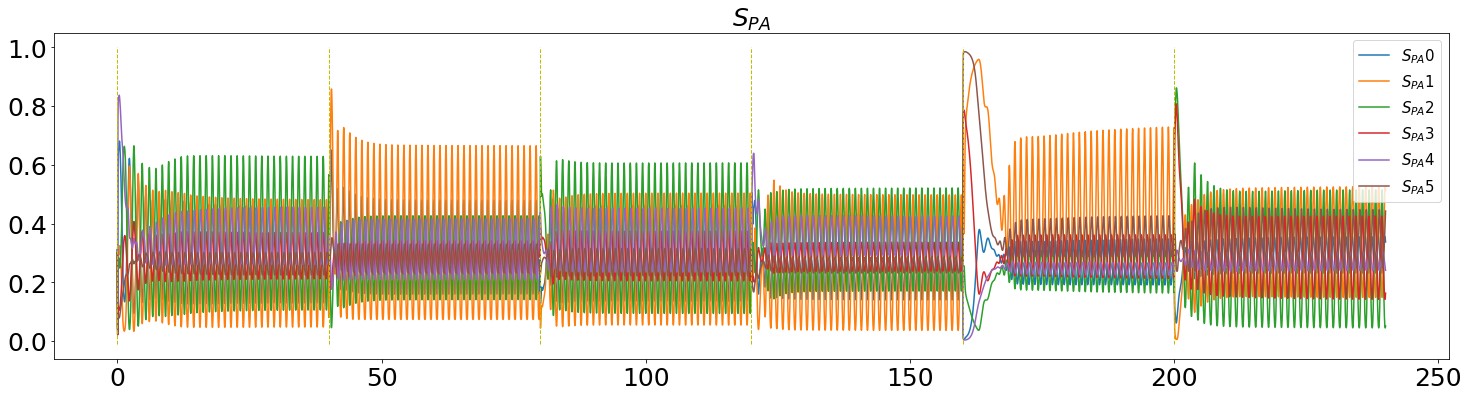

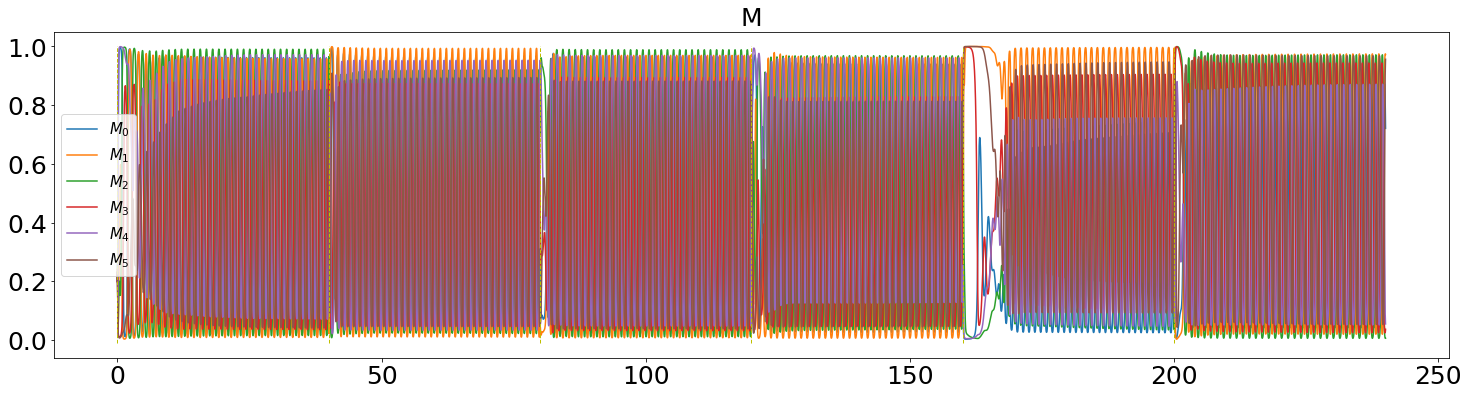

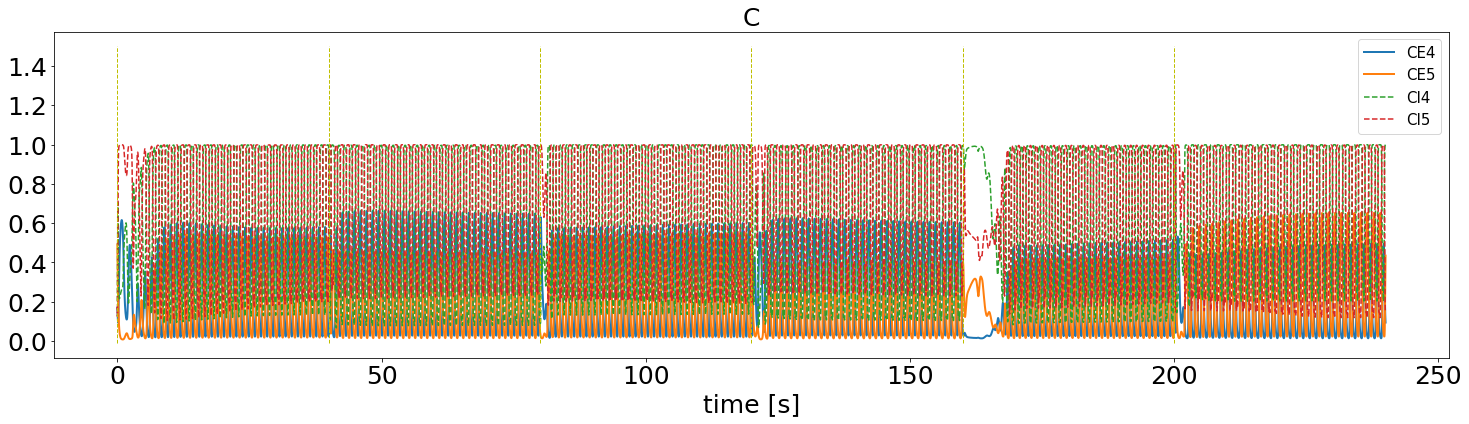

In [16]:
tic_s = 25 # tick label size
tit_s = 25 # title size
leg_s = 15 # legend text size
lab_s = 25 # axis label font size
arm_activs = plant_data_l[P]

u_to_disp = [0,1,2,3,4,5] # units to display
# SPF
redSPF = [SPF[u] for u in u_to_disp] # "reduced" SPF
fs = (25,6)
SPF_fig = plt.figure(figsize=fs)
SPF_ax = plt.gca()
SPF_ax.tick_params(axis='both', labelsize=tic_s)
SPF_data_l = np.array(data_l[redSPF])
plt.plot(times_l, SPF_data_l.transpose())
for rch in range(n_reaches_l): # plot a line at the onset of new targetsmichael chandler vs justin gaethje full fight
    rch_time = times_l[0] + t_pres_l*rch
    plt.plot([rch_time, rch_time], [-0.01, 1.], 'y--', linewidth=1)
#SPF_legends = ['$S_{PA}$'+str(i) for i in range(len(redSPF))]
SPF_legends = ['$S_{PA}$'+str(i) for i in u_to_disp]
plt.legend(SPF_legends, fontsize=15)
plt.title('$S_{PA}$', fontsize=tit_s)

# M
redM = [M[u] for u in u_to_disp] # "reduced" M
M_fig = plt.figure(figsize=fs)
M_data_l = np.array(data_l[redM])
plt.plot(times_l, M_data_l.transpose())
M_legends = ['$M_{'+str(i)+'}$' for i in u_to_disp]
for rch in range(n_reaches_l): # plot a line at the onset of new targets
    rch_time = times_l[0] + t_pres_l*rch
    plt.plot([rch_time, rch_time], [-0.01, 1.], 'y--', linewidth=1)
plt.legend(M_legends, fontsize=15)
plt.title('M', fontsize=tit_s)
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)

if use_syne:
    # SYNE, SYNI
    n_syn_f = 4 # how many unit pairs to plot
    SYN_fig = plt.figure(figsize=fs)
    SYNE_data_l = np.array(data_l[SYNE[:n_syn_f]])
    SYNI_data_l = np.array(data_l[SYNI[:n_syn_f]])
    plt.plot(times_l, SYNE_data_l.transpose(), linewidth=2)
    plt.plot(times_l, SYNI_data_l.transpose(), '--')
    SYN_legends = ['SYNE'+str(i) for i in range(n_syn_f)]
    SYN_legends += ['SYNI'+str(i) for i in range(n_syn_f)]
    plt.legend(SYN_legends, fontsize=leg_s)
    plt.title('SYN', fontsize=tit_s)
    plt.xlabel('time [s]', fontsize=lab_s)
    plt.xticks(fontsize=tic_s)
    plt.yticks(fontsize=tic_s)
    for rch in range(n_reaches_l): # plot a line at the onset of new targets
        rch_time = times_l[0] + t_pres_l*rch
        plt.plot([rch_time, rch_time], [-0.5, 1.5], 'y--', linewidth=1)
    
    # M--SYNE0 weights
    W_fig1 = plt.figure(figsize=fs)
    w_track_data_l = np.array(data_l[M_SYNE0_track])
    plt.plot(times_l, w_track_data_l.transpose())
    M_SYNE0_legends = ['M'+str(i)+'--SYNE0' for i in range(len(M_SYNE0_track))]
    plt.legend(M_SYNE0_legends)
    plt.title('M--SYNE0 weights', fontsize=tit_s)
    plt.xticks(fontsize=tic_s)
    plt.yticks(fontsize=tit_s)
    for rch in range(n_reaches_l): # plot a line at the onset of new targets
        rch_time = times_l[0] + t_pres_l*rch
        plt.plot([rch_time, rch_time], [-0.01, 1.5], 'y--', linewidth=1)
else:
    # C
    cu_to_disp = [4,5] # units to display
    redCE = [CE[u] for u in cu_to_disp]
    redCI = [CI[u] for u in cu_to_disp] 
    C_fig = plt.figure(figsize=fs)
    CE_data_l = np.array(data_l[redCE])
    CI_data_l = np.array(data_l[redCI])
    plt.plot(times_l, CE_data_l.transpose(), linewidth=2)
    plt.plot(times_l, CI_data_l.transpose(), '--')
    C_legends = ['CE'+str(i) for i in cu_to_disp]
    C_legends += ['CI'+str(i) for i in cu_to_disp]
    plt.legend(C_legends, fontsize=leg_s)
    plt.title('C', fontsize=tit_s)
    plt.xlabel('time [s]', fontsize=lab_s)
    plt.xticks(fontsize=tic_s)
    plt.yticks(fontsize=tic_s)
    for rch in range(n_reaches_l): # plot a line at the onset of new targets
        rch_time = times_l[0] + t_pres_l*rch
        plt.plot([rch_time, rch_time], [-0.01, 1.5], 'y--', linewidth=1)

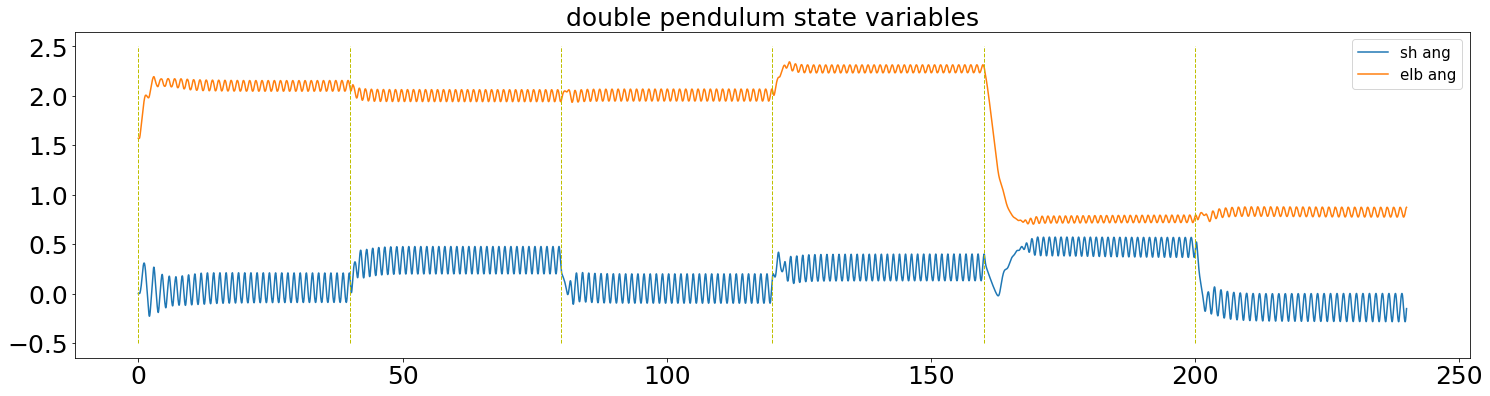

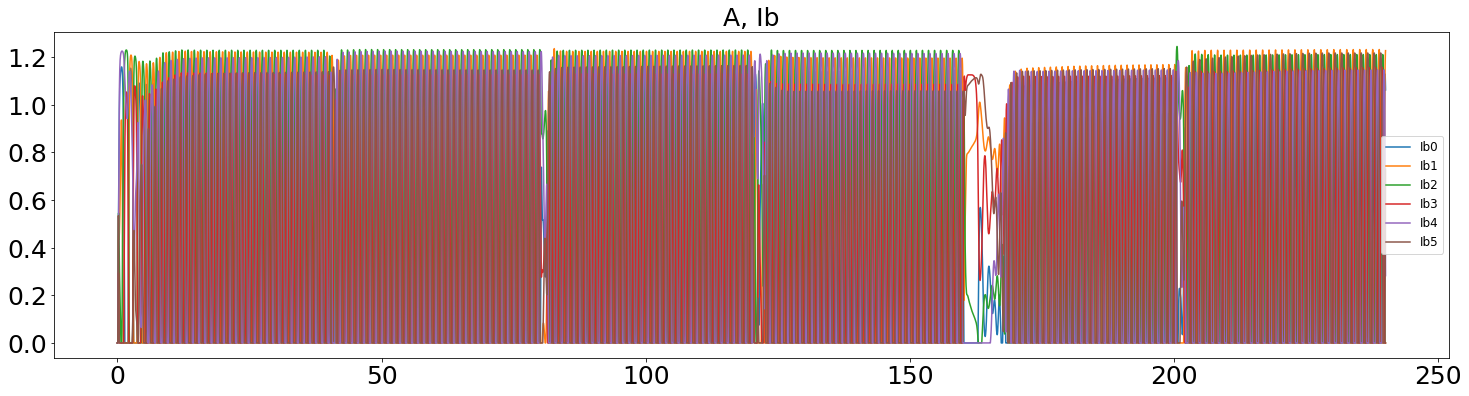

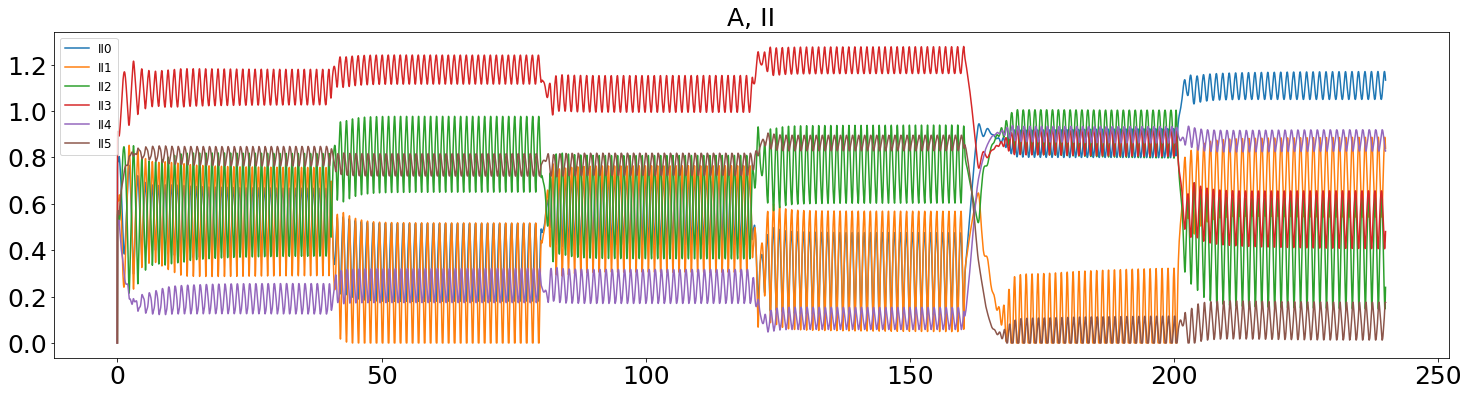

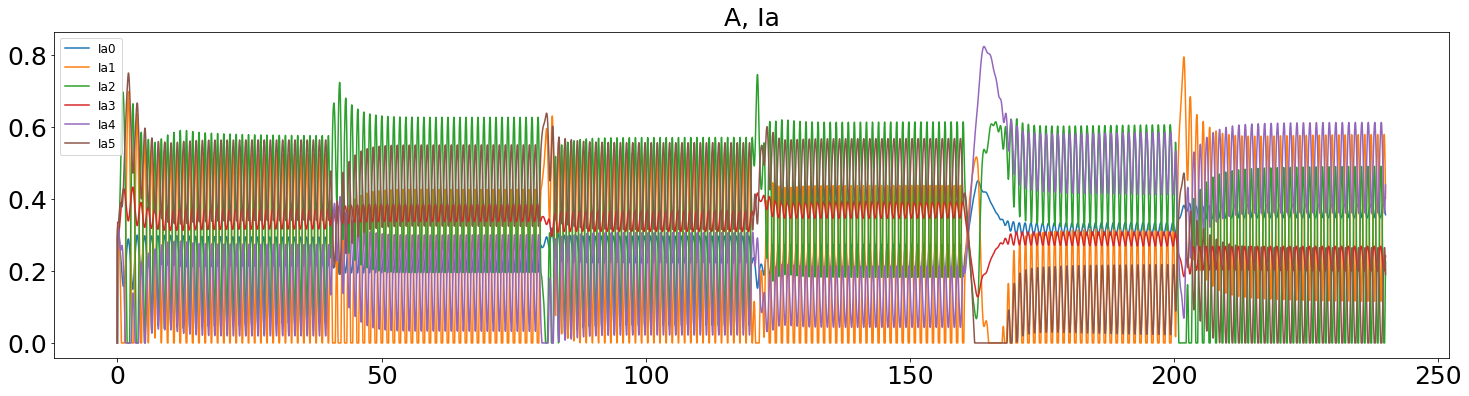

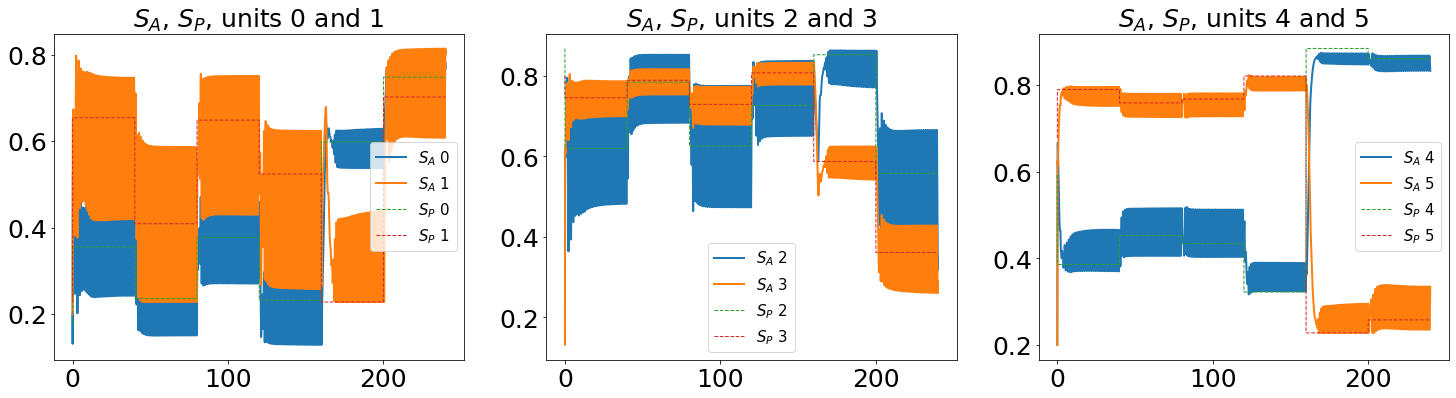

In [20]:
# P
P_fig = plt.figure(figsize=fs)
P_state = plant_data_l[P][:,0:4:2]
plt.plot(times_l, P_state)
#plt.legend(['sh ang', 'sh ang vel', 'elb ang', 'elb ang vel'])
plt.legend(['sh ang', 'elb ang',], fontsize=leg_s)
plt.title('double pendulum state variables', fontsize=tit_s)
#plt.xlabel('time [s]', fontsize=lab_s)
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)
for rch in range(n_reaches_l): # plot a line at the onset of new targets
    rch_time = times_l[0] + t_pres_l*rch
    plt.plot([rch_time, rch_time], [-0.5, 2.5], 'y--', linewidth=1)

# A
A_fig = plt.figure(figsize=fs)
A_data_l = np.array(data_l[A[0:6]])
plt.plot(times_l, A_data_l.transpose())
A_legends = ['Ib' + str(i) for i in range(6)]
plt.legend(A_legends, fontsize=12)
plt.title('A, Ib', fontsize=tit_s)
#plt.xlabel('time [s]', fontsize=lab_s)
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)

A_fig2 = plt.figure(figsize=fs)
A_data_l2 = np.array(data_l[A[12:18]])
plt.plot(times_l, A_data_l2.transpose())
A_legends2 = ['II' + str(i) for i in range(6)]
plt.legend(A_legends2, fontsize=12)
plt.title('A, II', fontsize=tit_s)
#plt.xlabel('time [s]', fontsize=lab_s)
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)

A_fig3 = plt.figure(figsize=fs)
A_data_l3 = np.array(data_l[A[6:12]])
plt.plot(times_l, A_data_l3.transpose())
A_legends3 = ['Ia' + str(i) for i in range(6)]
plt.legend(A_legends3, fontsize=12)
plt.title('A, Ia', fontsize=tit_s)
#plt.xlabel('time [s]', fontsize=lab_s)
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)

#fs = (30,6)
# SF, SP
SF_fig, axs = plt.subplots(1, 3, figsize=(fs[0], fs[1]))
for ax in axs.flatten(): 
    ax.tick_params(axis='both', labelsize=tic_s)
SF_data_l = np.array(data_l[SF])
SP_data_l = np.array(data_l[SP])
if 'lowpass_SP' in locals() and lowpass_SP is True:
    LPF_SP_data_l = np.array(data_l[LPF_SP])
for col in range(3):
    ax = axs[col]
    base = 2*col
    ax.plot(times_l, SF_data_l[base:base+2, :].transpose(), linewidth=2)
    ax.plot(times_l, SP_data_l[base:base+2, :].transpose(), '--', linewidth=1)
    if 'lowpass_SP' in locals() and lowpass_SP is True:
        ax.plot(times_l, LPF_SP_data_l[base:base+2, :].transpose(), linewidth=2)
    ax.set_title('$S_A$, $S_P$, units %d and %d' % (base, base+1), fontsize=tit_s)
    SF_legends = ['$S_A$ '+ str(base+i) for i in range(2)]
    SP_legends = ['$S_P$ '+ str(base+i) for i in range(2)]
    ax.legend(SF_legends + SP_legends, fontsize=leg_s)

plt.show()

In [21]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y


plant = net.plants[P]
# modified copy-paste of plt.upd_ip_impl
q1 = arm_activs[:,0]
q2 = arm_activs[:,2]
q12 = q1+q2
c_elbow = np.array((plant.l_arm*np.cos(q1), plant.l_arm*np.sin(q1)))
c_hand = np.array((c_elbow[0] + plant.l_farm*np.cos(q12),
                   c_elbow[1] + plant.l_farm*np.sin(q12))).transpose()
if 'start_t' in locals():
    coord_idxs = np.floor((times_l-start_t)/t_pres_l).astype(int) # after resetting the targets
    des_coords = np.array([hand_coords[idx] for idx in [m_idxs[cid] for cid in coord_idxs]])
else:
    coord_idxs = np.floor(times_l/t_pres_l).astype(int)  # before resetting the targets
    des_coords = np.array(hand_coords)[m_idxs[coord_idxs],:] # desired coordinates at each moment in time
coords_fig = plt.figure(figsize=fs)
plt.plot(times_l, c_hand)
plt.plot(times_l, des_coords)
plt.title('desired vs. actual hand coordinates', fontsize=tit_s)
plt.legend(['X', 'Y', 'des_X', 'des_Y'], fontsize=leg_s)
#plt.xlabel('time [s]', fontsize=lab_s)
plt.ylabel('coordinate [m]', fontsize=lab_s)
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)

act_fig = plt.figure(figsize=fs)
act_data_l = np.array(data_l[ACT])[0]
plt.plot(times_l, act_data_l)
plt.plot(times_l, 0.8*np.ones_like(times_l), 'k--')
plt.title('ACT', fontsize=tit_s)
plt.xlabel('time [s]', fontsize=lab_s)
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)

err_fig = plt.figure(figsize=fs)
w_len = 1001
hand_error = np.linalg.norm(c_hand-des_coords, axis=1)
smooth_hand_error = smooth(hand_error, window_len=w_len)[int(np.floor(w_len/2)):-int(np.floor(w_len/2))]
#plt.plot(times_l, smooth_hand_error)
plt.plot(times_l, hand_error, 'r')
plt.plot(times_l, 0.1+np.zeros(smooth_hand_error.size), 'k--')
plt.title('distance from target', fontsize=tit_s)
for rch in range(n_reaches_l): # plot a line at the onset of new targets
    rch_time = times_l[0] + t_pres_l*rch
    plt.plot([rch_time, rch_time], [-0.01, .6], 'y--', linewidth=1)
#plt.xlabel('time [s]', fontsize=lab_s)
plt.ylabel('error [m]', fontsize=lab_s)
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)

avg_error = hand_error.sum()/hand_error.size
print("average error: %f" % (avg_error))


plt.show()

NameError: name 'hand_coords' is not defined

In [ ]:
# Parallel runs of 'reach_ana' with pathos
n_procs = 20
print('Starting %d processes' % (n_procs))
start_time = time.time()
pool = ProcessingPool(nodes=n_procs)
all_results = pool.map(reach_ana, all_configs)
print('\n****** Processing finished after %s seconds ******' % (time.time() - start_time))

Starting 20 processes


/home/z/projects/draculab/requirements/requirements.py:1456: UserWarning: setting the 0 value for the acc_slow reset port
  warn('setting the 0 value for the acc_slow reset port')
/home/z/projects/draculab/requirements/requirements.py:1456: UserWarning: setting the 0 value for the acc_slow reset port
  warn('setting the 0 value for the acc_slow reset port')
/home/z/projects/draculab/requirements/requirements.py:1456: UserWarning: setting the 0 value for the acc_slow reset port
  warn('setting the 0 value for the acc_slow reset port')
/home/z/projects/draculab/requirements/requirements.py:1456: UserWarning: setting the 0 value for the acc_slow reset port
  warn('setting the 0 value for the acc_slow reset port')
/home/z/projects/draculab/requirements/requirements.py:1456: UserWarning: setting the 0 value for the acc_slow reset port
  warn('setting the 0 value for the acc_slow reset port')
/home/z/projects/draculab/requirements/requirements.py:1456: UserWarning: setting the 0 value for th

In [ ]:
# save the results
import pickle
fname = time.strftime('/home/z/Dropbox (OIST)/saves/reach_anaD_%Y-%m-%d', time.localtime())
all_conf_res = (all_configs, all_results)
with open(fname, 'wb') as f:
    pickle.dump(all_conf_res, f)
    f.close()

In [17]:
# load results
fname = '/home/z/Dropbox (OIST)/saves/reach_anaD_2022-07-18'
with (open(fname, "rb")) as f:
    all_configs, all_results = pickle.load(f)
    f.close()

In [15]:
for conf, res in zip(all_configs, all_results):
    print(conf['label'], end=', ')
    print(res['first_reach'])

STATIC_CONN, None


In [17]:
all_results

[{'error_l': 0.26449899622039563,
  'error_l_4': 0.2844480980055707,
  'first_reach': None,
  'error_r': 0.05226535873349976,
  'cs_of_d': array([0.69441654, 0.98692679, 0.96026801, 0.59774334, 0.89329839,
         0.96493812, 0.81271255, 0.97981149, 0.96785565, 0.67078802,
         0.86715779, 0.95673481]),
  'R_pred': 0.94398090762324,
  'n_tuned': 6,
  'pred_frac': 0.375,
  'bimodal': True,
  'sc_dom_ang_deg': 60.553304935582254,
  'var_per': 0.35969291645944274}]

In [34]:
cfg = {
        'A__C_lrate': 22.5,
        'A__C_w_max_frac': 0.32,
        'A__C_w_sum': 2.0,
        'A__M_lrate': 26.17,
        'A__M_w_max_frac': .2,
        'A__M_w_sum': 1.,
        'AL_thresh': 1.1,
        'b_e': 1.0,
        'C__C_antag': 1.83,
        'C__C_p_antag': 0.16,
        'C__C_p_syne': 0.18,
        'C__C_syne': 0.5,
        'C_adapt_amp': 0.0,
        'C_cid': 0.15,
        'C_sigma': 0.4,
        'C_slope': 1.7,
        'C_tau': 0.15,
        'C_tau_slow': 11.0,
        'CE_thresh': 2.13,
        'CE__CI_w': 0.5,
        'CI__CE_w': -1.8,
        'CI_slope': 3.44,
        'CI_tau': 0.018,
        'CI_thresh': 1.63,
        'g_e_03': 22.37,
        'g_e_factor': 3.0,
        'II_g_03': 7.46,
        'k_pe_e': 20.0,
        'k_se_e': 20.0,
        'M_adapt_amp': 0.,
        'M__AL_lrate': 0.,
        'M__AL_w_sum': 1.5, #2.86,
        'M__C_lrate': 0.,
        'M__C_w_sum': 1.5, # 0.5
        'M__M_w': -1.0,
        'M_cid': 1.1,
        'M_des_out_w_abs_sum': 2.52,
        'M_tau': 0.05,
        'M_slope': 3.35,
        'M_thresh': 0.68,
        'SF_thresh_03': 0.75,
        'SPF__M_lrate': 500.0,
        'SPF__M_w_sum': 3.73,
        'SPF_des_out_w_abs_sum': 2.98,
        'SPF__SPF_w': -1.77,
        'fitness': 0.024913803408415137,
        'n_evals': 2,
        't_pres': 40.,
        'SF_slope': 3.05
    }

cfg[name] == all_configs[29]['cfg'][name]


True

In [47]:
# For each configuration, get its mean and std values

# first, eliminate identical copies in all_configs, and put all results
# from the same parameter configuration in a list
res_template = {'error_l': [],
                'error_l_4': [],
                'first_reach': [],
                'error_r': [],
                'cs_of_d': [],
                'R_pred': [],
                'n_tuned': [],
                'bimodal': [],
                'sc_dom_ang_deg': [],
                'var_per': [] }
unique_arg_dicts = [all_configs[0]]
unique_num = 0
res_dict_list = [copy.deepcopy(res_template)]
for dic_num, arg_dict in enumerate(all_configs):
    if arg_dict != unique_arg_dicts[unique_num]:
        unique_num += 1
        res_dict_list.append(copy.deepcopy(res_template))
        unique_arg_dicts.append(arg_dict)
        
    for name in all_results[dic_num]:
        if name in res_dict_list[unique_num]:
            res_dict_list[unique_num][name].append(all_results[dic_num][name])
#             for name2 in res_dict_list[unique_num]:
#                 if name1 == name2:
#                     res_dict_list[unique_num][name2].append(all_results[dic_num][name1])
#                     break
                    
# get mean and std from res_dict_list
res_stats = [] # mean and std for each unique configuration
for rdict in res_dict_list:
    stat_dict = {}
    for name in rdict:
        if name == 'first_reach':
            if rdict[name]
        if len(rdict[name])>0 and rdict[name][0] != None: # if not empty
            stat_dict[name] = (np.mean(rdict[name]), np.std(rdict[name]))
    res_stats.append(stat_dict)

[None]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [49]:
a = [[.5, .6], [1, 3]]
if len(a) > 0 and a[0]:
    print('ye')

ye


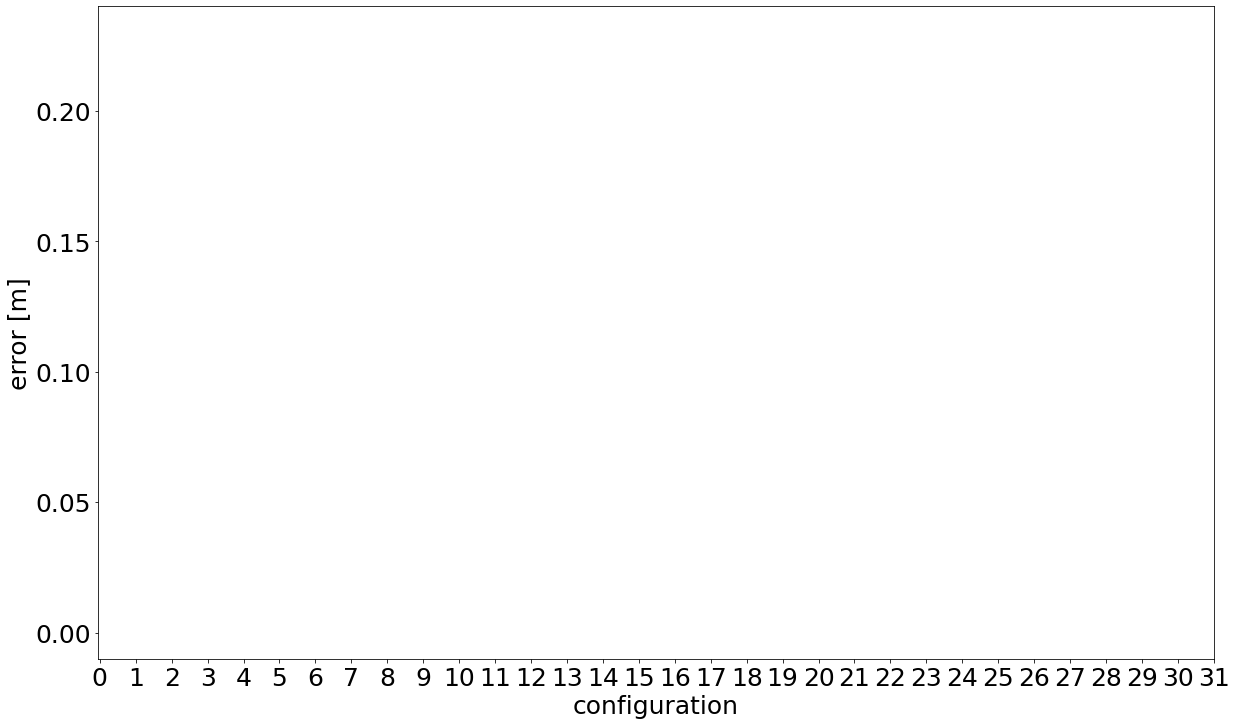

In [27]:
# For all configurations, display one value
to_disp = 'error_r'
m_fig = plt.figure(figsize=(20,12))
plt.ylim([-0.01, 0.24])
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('configuration', fontsize=25)
plt.ylabel('error [m]', fontsize=25)

# quick way
m_vals = [r[to_disp][0] for r in res_stats]
plt.plot(m_vals, '*')
plt.xticks(list(range(32)))

# more complete way
# used_labels = []
# for idx, cfg in enumerate(unique_arg_dicts):
#     color2 = 'r'

#     if cfg['cfg'] == pop_gene17[0]:
#         label = '17_0'; color='k'
#     elif cfg['cfg'] == pop_gene17[1]:
#         label = '17_1'; color='y'
#     elif cfg['cfg'] == pop_gene17[2]:
#         label = '17_2'; color='b'
#     elif cfg['cfg'] == pop_gene19[0]:
#         label = '19_0'; color='c'
#     elif cfg['cfg'] == pop_gene19[1]:
#         label = '19_1'; color='g'
#     elif cfg['cfg'] == pop_gene19[2]:
#         label = '19_2'; color='m'
#     elif cfg['cfg'] == pop_pso28[0]:
#         label = '28_0'; color='r'; color2='k'
#     elif cfg['cfg'] == pop_pso28[1]:
#         label = '28_1'; color='g'; color2='y'
#     elif cfg['cfg'] == pop_pso28[2]:
#         label = '28_2'; color='w'; color2='k'
#     elif cfg['cfg'] == pop_gene25[0]:
#         label = '25_0'; color=[0.5, .1, 0.8, .1]; color2=[0.5, 0.1, 0.3, .8]
#         print('yeah')
#     elif cfg['cfg'] == pop_gene25[1]:
#         label = '25_1'; color=[0.1, 0.8, 0.1, .1]; color2=[0.1, .9, 0.1, .5]
#         print('yeah')
#     else:
#         label = 'error'; color=[0.1, 0.8, 0.1, .4]; color2=[0.1, .9, 0.9, .5]
#     if label in used_labels:
#         label = ''
#     else:
#         used_labels.append(label)
#     plt.plot([idx, idx], [0, 0.1*res_stats[idx][to_disp][0]], color=color, label=label, linewidth=6)
#     plt.plot([idx, idx], [0, 0.1*res_stats[idx][to_disp][0]], color='k', linewidth=6)
    
#     avg = res_stats[idx][to_disp][0]
#     std = res_stats[idx][to_disp][1]
#     if cfg['use_syne']:
#         if idx < 2:
#             plt.plot([idx, idx], [0, avg], c=color2, label='synergetic C', linewidth=8)
#         else:
#             plt.plot([idx, idx], [0, avg], c=color2, linewidth=8)
#     else:
#         if idx < 1:
#             plt.plot([idx, idx], [0, avg], 'k', label='standard C',linewidth=8)
#         else:
#             plt.plot([idx, idx], [0, avg], 'k', linewidth=8)
#     if cfg['new_gain'] > 1.01:
#         if idx < 5:
#             plt.plot([idx], [avg], 'g*', markersize=25, label='high gain')
#         else:
#             plt.plot([idx], [avg], 'g*', markersize=25)
# #     if cfg['new_noise'] > 0:
# #         if idx < 5:
# #             plt.plot([idx], [0], 'b^', label='noisy', markersize=15)
# #         else:
# #             plt.plot([idx], [0], 'b^', markersize=15)
#     if cfg['rot_SPF']:
#         #vals = avg * np.linspace(.1, .8, 10)
#         if idx < 1:
#             #plt.plot([idx]*10, vals, 'co', label='rotSPF', markersize=10)
#             plt.plot([idx], [0.], 'co', label='mixed $S_{PA}$', markersize=20)
#         else:
#             #plt.plot([idx]*10, vals, 'co', markersize=10)
#             plt.plot([idx], [0.], 'co', markersize=20)
            
#     plt.plot([idx-0.1, idx+0.1], [avg-std, avg-std], 'y', linewidth=5)
#     plt.plot([idx-0.1, idx+0.1], [avg+std, avg+std], 'y', linewidth=5)
#     #plt.plot([idx, idx], [avg, avg-std], 'y--')
#     plt.plot([idx, idx], [avg+0.05*std, avg+std], 'y--')
# plt.title(to_disp, fontsize=30)
# plt.legend(fontsize=18)
plt.show()

In [28]:
m_vals

[]

In [42]:
(np.array(res_dict_list[1]['error_r']) < 0.05).sum()

14

In [ ]:
# sort results according to a "score" value
def score_result(res):
    """ Test the properties of a simulation result.
    
        In this context, good properties (which raise the score) are:
        1* error_l and error_r are below threshold values.
        2* At least 80% of the cs_of_d values are above a threshold.
        3* n_tuned is 8 or more (assuming tuning analysis uses 12 units).
        4* pred_frac is above 0.4
        5* bimodal PD distribution
        6* max_var_per, max_orth_fr, and max_vp_of are beyond threshold values
        Args:
            res : results dictionary as returned by reach_ana.
            
        Returns:
            A score indicating the "goodness" of the simulation.
    """
    score = 0.
    if res['error_l'] < 0.1: score += 1.
    if res['error_r'] < 0.05: score += 4.
    score += 3.*(0.5 - res['error_r'])
    cod = res['cs_of_d']
    if (cod > 0.8).sum() / cod.size > 0.8: score += 1.
    if res['pred_frac'] > 0.4: score += 1.
    if res['bimodal']: score += 3.
    if res['max_var_per'] > 0.7: score += 1 + res['max_var_per']
    if res['max_orth_fr'] > 0.4: score += 1 + res['max_orth_fr']
    if res['max_vp_of'] > 0.2: score += 2 + 2 * res['max_vp_of']
        
    return score

# make sure you join the argument dictionary, or the result will be lost after sorting
for idx, result in enumerate(all_results):
    result['arg_dict'] = arg_dicts[idx]

# sort
all_results.sort(key = score_result)
    

In [ ]:
# basic info of the best configurations

# assuming this is the list of the paramter dictionaries tested
# cfg_list = [pop_gene17[0], pop_gene17[1],
#             pop_gene24[0], pop_gene24[1],
#             pop_pso24[0], pop_pso28[0]]
cfg_names = ['gene17_0', 'gene17_1',
             'gene24_0',  'gene24_1',
             'pso24_0', 'pso28_0']

all_scores = [score_result(res) for res in all_results]
cfg_name = "unidentified"
for rid in 215 - np.arange(25):
    ar = all_results[rid]
    ad = ar['arg_dict']
    for idx, cfg in enumerate(cfg_list):
        if ad['cfg'] == cfg:
            cfg_name = cfg_names[idx]
    #print('\n')
    print("%d: cfg = %s,\t use_syne = %r,\t gain = %.1f,\t noise=%.1f,\t r=%.1f,\t error_r=%.3f,\t score=%.2f" % 
          (rid, cfg_name, ad['use_syne'], ad['new_gain'], ad['new_noise'], ad['r'], ar['error_r'], all_scores[rid]))

In [13]:
for idx, result in enumerate(all_results):
    if result['bimodal']:
        print(idx)

0
1


---

In [ ]:
all_results[0]